# Virtual Mile of Miles: Building a Monte Carlo Statistical Model in 3 days

Running clubs in the Greater Southampton area annually compete in the 'Mile of Miles' team competition, typically held in June. Given the cancellation of events in 2020, my club decided to replicate it with our own, virtual event.
***
In this virtual Mile of Miles, there are 12 teams of 10 runners, drawn randomly from a hat beforehand. Each team member completes the fastest 1 mile time they can, at any time, on any net zero elevation route in a set week. 
***
The team's time is the summation of the each team member's 1 mile time. Every second counts!
***
A friend messaged me and asked if I fancied guessing the outcome. Given his challenge, I decided to build a simple statistical model to simulate the event using some simple, data-driven statistics. I did this in 3 days in June, 2020, in between doing my PhD in Astrophysics at Univeristy of Southampton.
***
Below is the Jupyter notebook in which I display my method, outlining both its strengths and pitfalls!

In [639]:
import re
import numpy as np
import numpy.random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import curve_fit

from tqdm import tqdm

In [4]:
%matplotlib inline

# Data

The data for this analysis started life as an Excel spreadsheet with the names of the 120 participants -- whose names have been removed.
***
1 mile races are uncommon. However, in addition to the annual Mile of Mile events, my club have annually hosted a summer series of 1 mile events, known as the 'Magic Mile', hosted on Southampton Common. We can use historical data from these events.
***
In order to estimate and later simulate each individual's 1 mile time, I need to find a relation between some readily avaliable data and the limited historic 1 mile data I do have.
***
Data from timed 5k events are readily accessible. This mainly comes from parkrun events, which are free, weekly, timed 5k events which are hosted across UK (and worldwide). Southampton parkrun reguarly attracts over 1000 runners, and most runners in this competition have completed at least one of these events in 2020.
***
For each individual I pulled their fastest 5km time of 2020, at Southampton if possible, from the parkrun database. For the small number that this didn't apply to, I took the individual's best 5km time in 2019 or a quick, general estimation from their training group. I added these data to the spreadsheet.
***
I pulled the last 3 years worth of 1 mile race data and matched results to any participant in this competition. Many runners have not completed a 1 mile race, but some have completed many. It is these data that we will use to form a predictive relation, which forms the basis of the Monte-Carlo simulation.

In [605]:
# Load in the initial data:

df = pd.read_csv("Mile_of_miles.csv")  # Read the csv file containing runners and best 2020 5k & (all-time) mile times

df = df.drop(columns=['Team 1', 'Unnamed: 1']) # Drop unneccesary column names

df = df.drop(list(np.arange(131,152)))  # Drop empty end rows

df.head() # The resulting dataframe looks like this:

,5k,10k,MoM17,MoM18,MoM19,MM17a,MM17b,MM17c,MM17d,MM17e,MM18a,MM18b,MM18c,MM18d,MM18e,MM19a,MM19b,MM19c,MM19d,MM19e
0,29:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26:28:00,51:49:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26:09:00,52:55:00,NaN,NaN,NaN,07:03,NaN,06:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32:59:00,NaN,NaN,NaN,NaN,08:06,NaN,08:03,08:06,08:04,08:53,NaN,09:34,09:03,NaN,NaN,NaN,09:32,09:13,09:19


Each index represents a runner, the '5k' column their best 5k of 2020 (or 2019...etc), and any result from past 'Mile of Mile' (MoM) events or 'Magic Mile' (MM) events -- NaN values otherwise.

# Data search for 5k/Mile times

We now need some code to convert all historic 5k and mile times (stored in an Excel spreadsheet) to usable data.

In [6]:
miletimes = []  # Initialise lists for mile & 5k race times
fivektimes = []

for i,val in enumerate(df['5k']):  # Search down the 5k time column
    try:
        if np.isnan(val) == True:  # Null values are recorded as NaNs, continue past these
            continue

    except TypeError:
        pass  # This only hits those times, so can pass safely 

    # val = 5k time, recorded either as Min:Sec, or Min:Sec:00 in Excel
    
    if len(str(val)) > 6: # If format is XX:XX:XX 
        fivektime = float(val[:2])*60 + float(val[3:5]) # Convert times to seconds
    elif len(str(val)) < 6: # If format is XX:XX
        fivektime = float(val[:2])*60 + float(val[3:])  # Convert times to seconds

    counter = -1
    for (columnName, columnData) in df.iteritems():  # Iterate over columns of historic mile data
        counter += 1
        if counter < 2: # Ignore first 2 columns (5k/10k times)
            continue
        else:    
            col_value = columnData[i]
            try:
                if np.isnan(col_value) == True:  # Continue past null values
                    continue
            except TypeError:

                mile_time = float(col_value[:2])*60 + float(col_value[3:])  # Convert times to seconds
            
                fivektimes.append(int(fivektime))
                miletimes.append(int(mile_time))

# Regression using a linear model

For every individual who has completed at least 1 historic mile race, we compare their 1 mile time to their best 2020 5k time. This forms a linear relationship -- faster 5k runners, run faster 1 mile races. As shown below.

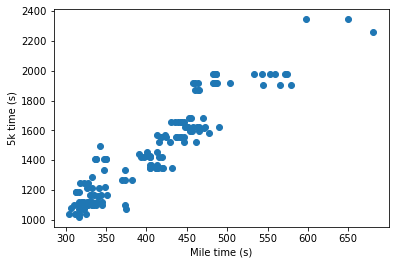

In [7]:
plt.figure()

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes, fivektimes)

## Model fitting

We want to describe this relation with a best fit, linear model. For this, I could manually define a loss function using maximum likelihood statsitics, but due to the nature of these data, a standard least-squares methodology will suffice. I thus use the scipy.optimize function 'curve_fit' to achieve this.

In [8]:
def linear_line(x, m, c):
    ''' Function to define our linear model '''
    y = m*x + c
    return y

And now fit our data with this linear model, using the scipy.optimize function 'curve_fit':

In [606]:
popt, pcov = curve_fit(linear_line, miletimes, fivektimes)  # curve_fit minimisation routine
m_min, c_min = popt  # Initial estimate model parameters 

# And we return our best fitting model:
x_plot = np.arange(300,700)

Model = linear_line(x_plot, m_min, c_min)  # Return our best fitting model

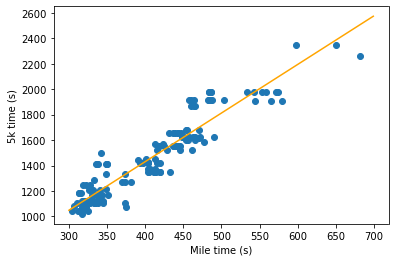

In [11]:
# Let's visualise this:

plt.figure()

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes, fivektimes)

plt.plot(x_plot, Model, color='orange')  # Plot on our model

## Bootstrap-with-replacement

I choose to use simple, frequentist statistics in this analysis. In order to describe the uncertainty in the linear model I use a bootstrap-with-replacement method, with the function I've written below. 
***
This method randomly selects data points from the sample, up to a number equal to the total sample, and is allowed to re-select the same data points multiple times. For N iterations of this process, we fit this new data-set with our maximum likelihood routine and form a discrete distribution of model parameters, from our linear model.
***
However, the data suffer from observational bias towards faster runners, particularly those with 5k times < 22mins. This effectively acts to 'pinch' the variability in the bootstrap distribution and does not give uncertainty ranges which are reflective of the inherent uncertainty in the model.

In [12]:
def Bootstrap_Continuum(N, Xs, Ys, m_guess, c_guess):
    ''' Function to perform a bootstrapping-with-replacement routine and return the modal results for a histogram distribution of parameters '''
    
    c_list = [] 
    m_list = []

    startindex = list(range(len(Xs)))  # Set up index range: (0 - last index in data set)
        
    for iter in range(N):
       
        index = np.random.choice(startindex, len(startindex), replace=True)                
        Rnd_Xs = Xs[index]  # Draws selection of random data from data-set 
        Rnd_Ys = Ys[index]  

        Boot_opt, Boot_cov = curve_fit(linear_line, Rnd_Xs, Rnd_Ys)  # Fit bootstrapped dataset as before
        m_boot, c_boot = Boot_opt  
   
        m_list.append(m_boot)  # Add these parameter fits to the list
        c_list.append(c_boot) 
        

    c_list = np.array(c_list)  # Return lists of parameters
    m_list = np.array(m_list)

    return m_list, c_list


In [13]:
# Let's run the bootstrap:

N = 500  # Number of bootstrap iterations
m_list, c_list = Bootstrap_Continuum(N, np.array(miletimes), np.array(fivektimes), m_min, c_min)

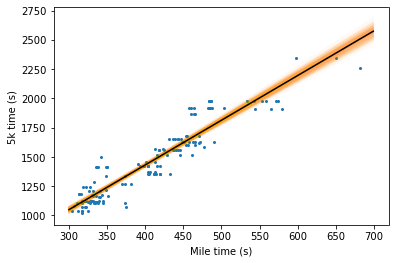

In [14]:
# And now plot the N models that the bootstrap has fitted

plt.figure()

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes, fivektimes, s=4)

for i in range(N):  # Plot each bootstrap iteration
    plt.plot(x_plot, linear_line(x_plot, m_list[i], c_list[i]), color='orange', alpha=0.01)  

plt.plot(x_plot, Model, color='black')  # And plot the maximum likelihood model

# Confidence Limits

The role of the bootstrap is to account for the inherent uncertainty on the model. I can set 1-sigma confidence limits above/below the model, by making the assumption of Gaussian-distributed errors around the maximum-likelihood fit.
***
I calculate the value of these 1-sigma confidence limits simply by finding the 68.3-percentile -- which represents the +1-sigma confidence limit -- across all 5k times. This is acceptable as I treat each time in isolation. The +1sigma value is then the simulated 68.3-percentile mile time subtracted from the most likely value mile time.
***
In summary, the line-of-best-fit (maximum likelihood) is the model's descriptor of the most likely mile time for a given 5k time, but the model attempts to account for uncertainty around this model with evensided errors, which are factored into the Monte Carlo.

In [607]:
fivek_range = np.arange(800, 3000)  # Range of reasonable 5k times

lines = np.ndarray(shape=(N, len(fivek_range)), dtype=float)  # Array for storing each iteration

for i in range(N):
    line = (fivek_range - c_list[i])/m_list[i]  # Consider each bootstrap fit
    lines[i,:] = line  # Store in array
    
std_devs = []

for i in range(len(fivek_range)):
    times = lines[:,i]  
    times = np.sort(times)  # For each 5k time (per second), list set of bootstrapped mile times, in order
    
    sig_plus = times[int(N*0.8415)] # Select percentile
    std_dev = sig_plus - np.median(times)  # 1 sigma level calculation
    std_devs.append(std_dev)  # List of standard deviations on the mile, for every 5k time
    

<ErrorbarContainer object of 3 artists>

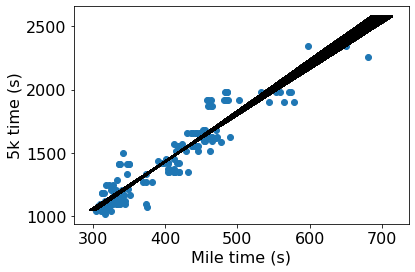

In [612]:
# Visualisation of the 1 sigma (68.3%) error ranges on the model

plt.figure()

x_plot_new = np.linspace(300,700,len(fivek_range))

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes,fivektimes)

plt.errorbar(x_plot_new, linear_line(x_plot_new, m_min, c_min), xerr=np.array(std_devs), color='black')

# Monte-Carlo

The role of the bootstrap is to account for the inherent uncertainty on the model. I can set 1-sigma confidence limits above/below the model, by making the assumption of Gaussian-distributed errors around the maximum-likelihood fit.
***
A Monte-Carlo method runs N iterations of random sampling to produce numerical results. We then collate the results of these simulations and consider the outcomes as frequency distributions -- which effectively the describe the pseudo-probability distributions for the projected outcomes of each given team within the competition.
***
I set this Monte-Carlo to run over 10,000 simulations, and in each, draws a random mile time for each runner based off their known 5k time, with inbuilt randomness set by the Gaussian errors, as described above. 

In [616]:
def MC(N_sim):
        
    Team_numbers = np.arange(1,13)  
    
    df_MC = pd.DataFrame()
    
    for team in tqdm(Team_numbers):  # Over all 12 teams
        
        All_Times = []

        for n in range(N_sim):  # Start MC running over N_sim iterations
            counter = 0
            Times = []

            for i,val in enumerate(df['5k']):  # Take 5k time of each runner

                try:
                    if np.isnan(val) == True:
                        continue
                except TypeError:
                    pass

                counter += 1  # Update counter for valid runner

                while counter > (team-1)*10 and counter <= team*10: # Set condition to identify team
                    
                    if len(str(val)) > 6:
                        time = float(val[:2])*60 + float(val[3:5])  # Sets 5k time in seconds
                    elif len(str(val)) < 6:
                        time = float(val[:2])*60 + float(val[3:])  # Sets 5k time in seconds


                    model_mile_time = (time - c_min) / m_min  # Predicted mile time based on model

                    index = np.argwhere(fivek_range == int(time))[0][0]  # Selects index of 5k time to nearest second

                    mile_draw = np.random.normal(model_mile_time, std_devs[index])  # Draws a random mile time based on assumed
                                                                                    # Gaussian nature using standard deviations
                                                                                    # from bootstrap


                    Times.append(mile_draw)  # Append the drawn mile time to a list
                    break

                if len(Times) == 10: # Once the full team (of 10 times) is complete

                    Team_time = np.sum(Times)  # Get the total team time
                    All_Times.append(Team_time)  # Append this to a main list
                    break


        df_MC['Team_{}'.format(team)] = All_Times  # Fill a dataframe of N_sim MC results      
        
            
    return df_MC

In [617]:
N_sim = 10000
df_MC = MC(N_sim)



  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:02<00:28,  2.60s/it]

 17%|█▋        | 2/12 [00:05<00:26,  2.68s/it]

 25%|██▌       | 3/12 [00:08<00:26,  2.91s/it]

 33%|███▎      | 4/12 [00:12<00:24,  3.11s/it]

 42%|████▏     | 5/12 [00:16<00:23,  3.32s/it]

 50%|█████     | 6/12 [00:20<00:21,  3.57s/it]

 58%|█████▊    | 7/12 [00:24<00:19,  3.84s/it]

 67%|██████▋   | 8/12 [00:29<00:16,  4.12s/it]

 75%|███████▌  | 9/12 [00:34<00:13,  4.40s/it]

 83%|████████▎ | 10/12 [00:40<00:09,  4.71s/it]

 92%|█████████▏| 11/12 [00:45<00:05,  5.02s/it]

100%|██████████| 12/12 [00:51<00:00,  4.33s/it]


In [618]:
df_rank = df_MC.rank(axis=1)

In [619]:
df_rank.head()

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
0,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
1,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
2,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
3,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
4,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0


# Results

The results consist of 100,000 simulated outcomes from the Monte-Carlo. It is trivial to compute team times for each iteration and do a frequency count of the position in which any team finished.

In [622]:
# The MC dataframe (and shape) now looks likes this, with each index corresponding to a different MC iteration

print(df_MC.shape)

df_MC.head()

(10000, 12)


,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
0,4495.22,4302.57,3966.54,3864.76,3950.86,4140.78,4241.93,3931.04,3784.80,3915.69,4283.53,4090.41
1,4477.88,4287.66,3961.92,3880.57,3943.82,4154.54,4236.10,3930.48,3796.74,3918.99,4287.49,4088.47
2,4481.93,4299.83,3984.92,3882.74,3958.62,4114.27,4239.07,3934.03,3799.45,3930.59,4279.47,4091.82
3,4474.09,4285.87,3984.76,3862.81,3932.61,4139.24,4258.68,3930.60,3799.36,3925.93,4274.38,4095.00
4,4509.35,4293.10,3962.44,3873.15,3940.53,4147.51,4259.35,3913.94,3794.93,3907.77,4284.84,4103.84


### Rankings

In [623]:
# The rankings of each team in a given iteration can be given by:

df_rank = df_MC.rank(axis=1)

# Which looks like this
df_rank.head()

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
0,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
1,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
2,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
3,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0
4,12.0,11.0,6.0,2.0,5.0,8.0,9.0,4.0,1.0,3.0,10.0,7.0


### Frequencies (i.e. percentages)

In [654]:
# We now create a df_Results dataframe which gives the frequency (in % form) that each team "finished" in a 
# given position/rank over all MC iterations

Indexes = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th']

df_Results = pd.DataFrame(columns = df_rank.columns, index=Indexes)  # Initialise dataframe

for i in df_rank:  # For each team
    Series = df_rank['{}'.format(i)].value_counts()  # Return value counts
    
    Frequency = np.zeros(12)
    
    for j,vals in enumerate(Series.index):
        Index = int(Series.index[j]) - 1
        Frequency[Index] = 100*Series.values[j]/N_sim  # Calculate % values of ranks
    
    df_Results['{}'.format(i)] = Frequency  # Fill in dataframe

In [655]:
# Which returns the full dataframe:
df_Results

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
1st,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.0,0.00,0.00,0.00
2nd,0.0,0.00,0.00,99.85,0.00,0.00,0.00,0.00,0.0,0.15,0.00,0.00
3rd,0.0,0.00,0.00,0.15,5.28,0.00,0.00,18.79,0.0,75.78,0.00,0.00
4th,0.0,0.00,0.11,0.00,17.92,0.00,0.00,61.46,0.0,20.51,0.00,0.00
5th,0.0,0.00,4.72,0.00,72.05,0.00,0.00,19.67,0.0,3.56,0.00,0.00
6th,0.0,0.00,95.17,0.00,4.75,0.00,0.00,0.08,0.0,0.00,0.00,0.00
7th,0.0,0.00,0.00,0.00,0.00,0.55,0.00,0.00,0.0,0.00,0.00,99.45
8th,0.0,0.00,0.00,0.00,0.00,99.45,0.00,0.00,0.0,0.00,0.00,0.55
9th,0.0,0.03,0.00,0.00,0.00,0.00,97.53,0.00,0.0,0.00,2.44,0.00
10th,0.0,10.01,0.00,0.00,0.00,0.00,2.45,0.00,0.0,0.00,87.54,0.00


# Data Visualisation

Let's visualise the results from the Monte-Carlo in a few different ways.

In [628]:
# Firstly with some dataframe styling 

with pd.option_context('display.precision', 2):

    cm = sns.light_palette("orange", as_cmap=True)

    Display = df_Results.style.background_gradient(cmap=cm)

In [630]:
# To set a colour scale which corresponds to frequency 
Display

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
1st,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00
2nd,0.00,0.00,0.00,99.85,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00
3rd,0.00,0.00,0.00,0.15,5.28,0.00,0.00,18.79,0.00,75.78,0.00,0.00
4th,0.00,0.00,0.11,0.00,17.92,0.00,0.00,61.46,0.00,20.51,0.00,0.00
5th,0.00,0.00,4.72,0.00,72.05,0.00,0.00,19.67,0.00,3.56,0.00,0.00
6th,0.00,0.00,95.17,0.00,4.75,0.00,0.00,0.08,0.00,0.00,0.00,0.00
7th,0.00,0.00,0.00,0.00,0.00,0.55,0.00,0.00,0.00,0.00,0.00,99.45
8th,0.00,0.00,0.00,0.00,0.00,99.45,0.00,0.00,0.00,0.00,0.00,0.55
9th,0.00,0.03,0.00,0.00,0.00,0.00,97.53,0.00,0.00,0.00,2.44,0.00
10th,0.00,10.01,0.00,0.00,0.00,0.00,2.45,0.00,0.00,0.00,87.54,0.00


In [638]:
# We can collect our results of the MC and reorder them to display the frequency 
# of finishing position both graphically and within a pandas DataFrame.

dic = {}  # Empty dictionary

for i,val in enumerate(df_Results.idxmax().to_list()):  # Identify index of maximum
    b = re.split('(\d+)', val)  # Split numbers and letters
    dic['{}'.format(b[1])] = 'Team_{}'.format(i+1)  # Fill dictionary with 
    
Order = []
for i in range(len(df_Results)):
    Order.append(dic['{}'.format(i+1)])  # Set order based on team position

df_Ordered = df_Results[Order]  # Create a new dataframe ordered by this logic

In [640]:
# Now let's implement the same styling as before on the new datframe:

with pd.option_context('display.precision', 2):

    cm = sns.light_palette("orange", as_cmap=True)

    Display_ordered = df_Ordered.style.background_gradient(cmap=cm)

In [641]:
# Nice, it is now a lot clearer!
Display_ordered

,Team_9,Team_4,Team_10,Team_8,Team_5,Team_3,Team_12,Team_6,Team_7,Team_11,Team_2,Team_1
1st,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2nd,0.00,99.85,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3rd,0.00,0.15,75.78,18.79,5.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4th,0.00,0.00,20.51,61.46,17.92,0.11,0.00,0.00,0.00,0.00,0.00,0.00
5th,0.00,0.00,3.56,19.67,72.05,4.72,0.00,0.00,0.00,0.00,0.00,0.00
6th,0.00,0.00,0.00,0.08,4.75,95.17,0.00,0.00,0.00,0.00,0.00,0.00
7th,0.00,0.00,0.00,0.00,0.00,0.00,99.45,0.55,0.00,0.00,0.00,0.00
8th,0.00,0.00,0.00,0.00,0.00,0.00,0.55,99.45,0.00,0.00,0.00,0.00
9th,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.53,2.44,0.03,0.00
10th,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.45,87.54,10.01,0.00


### Grid plot

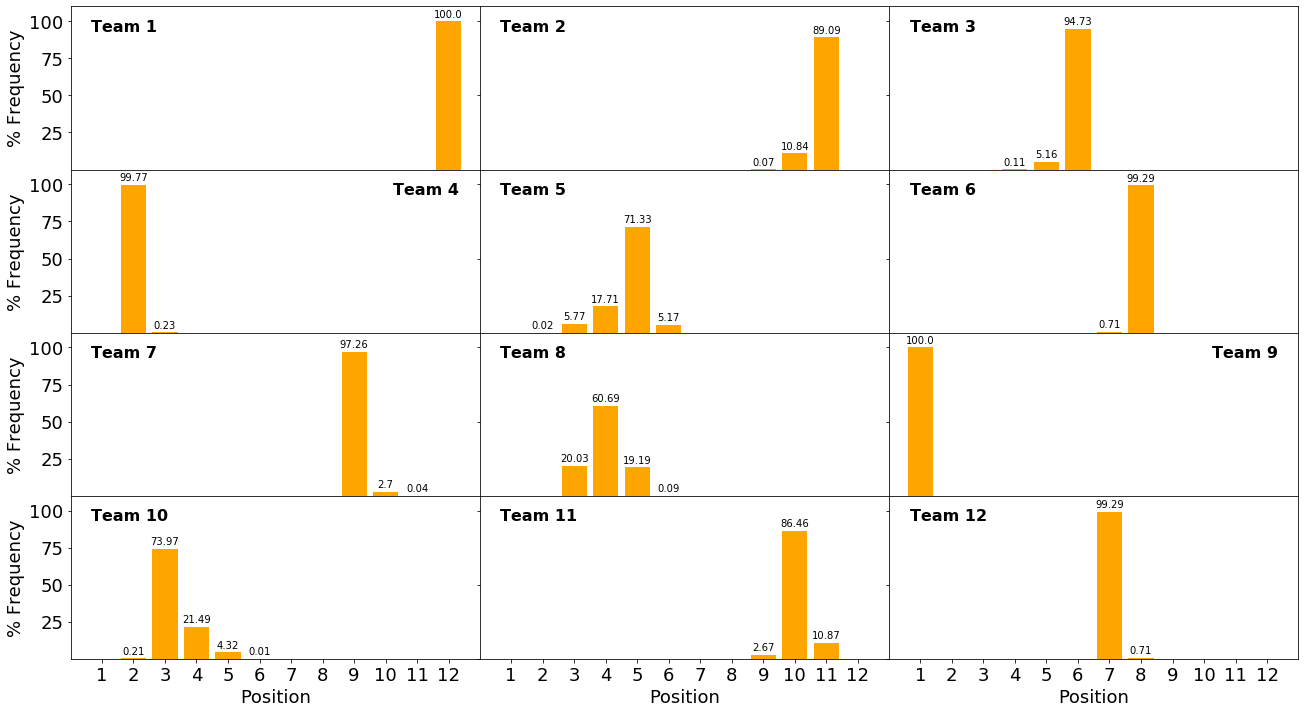

In [388]:
# Let's create a gridplot of these predicted results

fig, ax = plt.subplots(4,3, figsize=(22,12))
fig.subplots_adjust(wspace = 0, hspace = 0)

axes = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2], ax[2,0], ax[2,1], ax[2,2], ax[3,0], ax[3,1], ax[3,2]]

for i,x in enumerate(axes):
    x.set_ylim(0,110)
    
    if i > 8:  # Set x labels at bottom of grid only
        x.set_xlabel('Position')
        x.set_xticks(np.arange(14))
        
        xlabels = np.array([''])
        xlabels = np.append(xlabels, np.arange(1,13))
        xlabels = np.append(xlabels, '')
        x.set_xticklabels(xlabels)         
    else:
        x.set_xticklabels([])
        
    if i%3 == 0:  # Set y labels at LHS of grid only
        x.set_ylabel('% Frequency')
        x.set_yticks([25,50,75,100])
    else:
        x.set_yticklabels([])
        
    if i == 3 or i == 8:  # Add Team numbers
        x.text(0.95, 0.85,'Team {}'.format(i+1), fontsize=16, fontweight='bold', ha='right', transform=x.transAxes)
    else:
        x.text(0.05, 0.85,'Team {}'.format(i+1), fontsize=16, fontweight='bold', ha='left', transform=x.transAxes)
    
    x.bar(np.arange(1,13), df_Results['Team_{}'.format(i+1)].values, color='orange')  # Plot bar charts
    
    for j,val in enumerate(df_Results['Team_{}'.format(i+1)].values):
        if val == 0.0:
            continue
        x.text(np.arange(1,13)[j], val+3, val, fontsize=10, ha='center')  # Add %values to bars

plt.show()

# Prediciton Summary

The most striking takeaway of the model is the relative confidence of the team placings, clear examples being the ~100% confidence in Team 9 finishing in 1st place, and similarly Team 1 finishing last. The greatest uncertainty in team finish positions is the cluster around 3rd-6th with Teams 3, 5, 8 & 10.

The lack of overlap between predicted position is the first sign of an underestimation in the inherent uncertainty of the race, due to ineffective accounting of the random variability of individual performance. This is largely driven by the bootstrap determination of model errors being insufficient to capture large deviations from the input model, and that assuming Gaussian errors is similarly overly optismistic. More broadly, it may show that the (unweighted) input data from the smaller sample (i.e. input mile data) is not represenative of the larger sample of people involved in the race!

# Race Results (the following week)

The race results were published in the following week of June, which can now be taken for post-prediction analysis.

In [642]:
# Load in the new results data file

df_Race = pd.read_csv("Mile_of_miles_full_results.csv")

df_Race = df_Race.drop(columns=['Team 1', 'Unnamed: 1']) # Drop unneccesary column names as before

df_Race.head() # The resulting dataframe looks like this (see the 'Actual' column for the submitted 1 mile time):

,5k,10k,MoM17,MoM18,MoM19,MM17a,MM17b,MM17c,MM17d,MM17e,...,MM18b,MM18c,MM18d,MM18e,MM19a,MM19b,MM19c,MM19d,MM19e,Actual
0,29:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:20
1,26:28:00,51:49:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:22
2,28:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:52
3,26:09:00,52:55:00,NaN,NaN,NaN,07:03,NaN,06:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08:00
4,32:59:00,NaN,NaN,NaN,NaN,08:06,NaN,08:03,08:06,08:04,...,NaN,09:34,09:03,NaN,NaN,NaN,09:32,09:13,09:19,10:50


In [656]:
Team_result = []
Team_times = []

for time in df_Race['Actual'].values:  # Convert race times to seconds for all results
    time = str(time)
    try:
        time_secs = float(time.split(":")[0])*60 + float(time.split(":")[1])
        Team_times.append(time_secs)
    except IndexError:
        Team_result.append(np.sum(Team_times))
        Team_times = []
        continue
        
Team_result.append(np.sum(Team_times))    

df_Race_results = df_Results.copy()  # Copy dataframe

df_Race_results['Actual_secs'] = Team_result  # Fill in new column

In [662]:
# Which returns this dataframe (column is unordered)
df_Race_results

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12,Actual_secs
1st,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.0,0.00,0.00,0.00,4672.0
2nd,0.0,0.00,0.00,99.85,0.00,0.00,0.00,0.00,0.0,0.15,0.00,0.00,4468.0
3rd,0.0,0.00,0.00,0.15,5.28,0.00,0.00,18.79,0.0,75.78,0.00,0.00,4213.0
4th,0.0,0.00,0.11,0.00,17.92,0.00,0.00,61.46,0.0,20.51,0.00,0.00,3893.0
5th,0.0,0.00,4.72,0.00,72.05,0.00,0.00,19.67,0.0,3.56,0.00,0.00,3861.0
6th,0.0,0.00,95.17,0.00,4.75,0.00,0.00,0.08,0.0,0.00,0.00,0.00,4185.0
7th,0.0,0.00,0.00,0.00,0.00,0.55,0.00,0.00,0.0,0.00,0.00,99.45,4470.0
8th,0.0,0.00,0.00,0.00,0.00,99.45,0.00,0.00,0.0,0.00,0.00,0.55,4232.0
9th,0.0,0.03,0.00,0.00,0.00,0.00,97.53,0.00,0.0,0.00,2.44,0.00,3927.0
10th,0.0,10.01,0.00,0.00,0.00,0.00,2.45,0.00,0.0,0.00,87.54,0.00,3970.0


In [507]:
# Let's use another dictionary to order the dataframe properly

d = {}
Sorted_times = df_Results['Actual_secs'].sort_values().values  # Sort by race time
Team_order = []

for i,val in enumerate(df_rank):    
    d['{}'.format(df_Results['Actual_secs'][i])] = '{}'.format(val) # Fill the dictionary

for time in Sorted_times:
    Team_order.append(d['{}'.format(time)])  # Create the ordered list

In [523]:
# Now let's visualise these results

def style_specific_cell(x):
    with pd.option_context('display.precision', 2):
        colour = 'background-color: lightgreen'
        df1 = pd.DataFrame('', index=x.index, columns=x.columns)
        for i,val in enumerate(Team_order):
            loc = np.argwhere(val == x.columns.values)[0][0]
            df1.iloc[loc,i] = colour  # Highlight each finishing position in green

        return df1

pd.set_option('precision', 2)

df_Ordered.style.apply(style_specific_cell, axis=None)

,Team_9,Team_4,Team_10,Team_8,Team_5,Team_3,Team_12,Team_6,Team_7,Team_11,Team_2,Team_1
1st,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2nd,0.00,99.77,0.21,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3rd,0.00,0.23,73.97,20.03,5.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4th,0.00,0.00,21.49,60.69,17.71,0.11,0.00,0.00,0.00,0.00,0.00,0.00
5th,0.00,0.00,4.32,19.19,71.33,5.16,0.00,0.00,0.00,0.00,0.00,0.00
6th,0.00,0.00,0.01,0.09,5.17,94.73,0.00,0.00,0.00,0.00,0.00,0.00
7th,0.00,0.00,0.00,0.00,0.00,0.00,99.29,0.71,0.00,0.00,0.00,0.00
8th,0.00,0.00,0.00,0.00,0.00,0.00,0.71,99.29,0.00,0.00,0.00,0.00
9th,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.26,2.67,0.07,0.00
10th,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.70,86.46,10.84,0.00


## Predicted vs Actual comparison

In [663]:
# First, let's write in the predicted time for each runner

Predicted = []    
    
Team_numbers = np.arange(1,13)

for team in Team_numbers:  # Looping over all teams
    
    counter = 0
    extra_counter = 0

    for i,val in enumerate(df['5k']):

        try:
            if np.isnan(val) == True:
                continue
        except TypeError:
            pass

        counter += 1  # Update counter for valid runner
        
        while counter > (team-1)*10 and counter <= team*10:

            if len(str(val)) > 6:
                time = float(val[:2])*60 + float(val[3:5])  # Sets 5k time in seconds
            elif len(str(val)) < 6:
                time = float(val[:2])*60 + float(val[3:])  # Sets 5k time in seconds

            model_mile_time = (time - c_min) / m_min  # Predicted mile time based on model
            
            Predicted.append(round(model_mile_time,1))  # Round predicted time to 1dp 
            extra_counter += 1
            
            if extra_counter%10 == 0 and extra_counter != 0:  # Just for correct df formatting
                Predicted.append(np.nan)
            
            break

Predicted = Predicted[:-1]  # Remove last row for correct formatting 

df_Race['Predicted'] = Predicted  # Update dataframe

In [664]:
# Second, let's convert the race times to seconds for comparison

Actual_secs = []
for time in df_Race['Actual'].values:
    try:
        time_secs = float(time.split(":")[0])*60 + float(time.split(":")[1])  # Conversion of mins:secs to seconds
        Actual_secs.append(time_secs)
    except AttributeError:
        Actual_secs.append(np.nan)

df_Race['Actual_secs'] = Actual_secs  # Update dataframe

In [667]:
# Here is the result (looking at the columns of interest)
df_Race[['Actual_secs', 'Predicted']].head()

,Actual_secs,Predicted
0,440.0,481.5
1,442.0,441.2
2,472.0,480.7
3,480.0,436.2
4,650.0,543.5


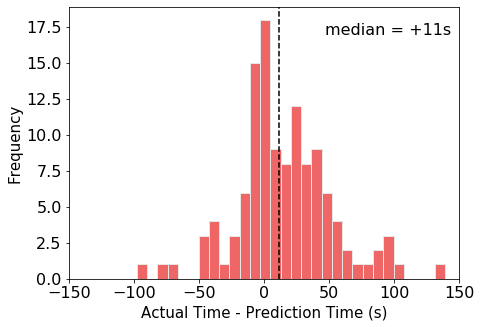

In [670]:
# Let's now do a direct comparison between race times and predicted times

diffs = df_Race['Actual_secs'] - df_Race['Predicted']  # Time difference

diffs = diffs.dropna()  # Remove NaN values (corresponding to empty rows in input data)


matplotlib.rcParams.update({'font.size': 16})

# Histogram figure 
plt.figure(figsize=(7,5))

plt.xlabel('Actual Time - Prediction Time (s)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

plt.hist(diffs, edgecolor='#E6E6E6', color='#EE6666', bins=30)  # Plot histogram

plt.axvline(np.median(diffs), color='black', linestyle='--')  # Plot median time difference

plt.xlim(-150,150)

plt.text(47,17, 'median = +{}s'.format(int(np.median(diffs))), fontsize=16)  # Display median time difference

plt.show()

In [691]:
# The precentage of mile times within +-11 seconds of their prediction:

100*np.sum(abs(diffs) < 11) / len(diffs)  # 33%

33.333333333333336

So we see that the model predicted mile time is a (median) average of 11 seconds below the actual mile time of runners in this sample.

# Summary: why the model fails and how to improve it

Of the 12 teams in the model, 7 produced results which were considered extremely low frequency occurances (<1%), including that of the winning team (Team 10). More broadly however, we find that the median prediction time is (only) 11 seconds out and the general trend of position predictions is certainly better than random chance, with only one team (Team 9) being more than 3 places removed from the model prediction. 

Hence, the question: why did the model fall down in some cases, and by extension, how can we improve the model?

We can start by considering a breakdown of the individual results, as in the histogram above. Considering each runner, we see the model on average is +11 seconds 'too optimistic' in predicting a mile time. From examining the shape of the histogram, we see exactly 1/3 of runners fall within +-11 seconds of their predicted time. The shape of this histogram conforms to a Gaussian distribution, with tails of the distribution reaching > +-50 seconds from their predicted time. It is likely that these few data points are responsible for the inaccuracy in the final predictions. This offers a simple explanation for Team 10's surprise victory. In this case, there was a single runner with a recorded 5k time of > 24 mins (in 2020), but was in fact capable of a < 20 mins 5k. It is clear that the Gaussian error assumptions on the model were insufficient to compensate for this input data. As such, Team 10 were modelled with a systematic 'time penalty' added to all simulations, which skewed their predictive outcomes. 

The nature of the input data is of central importance. The competition was run in unprecidented times, following three months without any races or training. The model used historic data of an event run without these restrictions, and with the aforementioned observation bias towards faster runners (who were more likely to both race mile distances, and do so consistently). The impact of the 2020 lockdown on amateur running participation, and form, is a greater topic which is well beyond the scope of this mini-review. I believe it is fair to assume the loss of group training has reduced the speed endurance of the average club runner, causing the model to overestimate the pace of the entire sample (hence the +11s median offset), however. To adjust for this systematic offset would require a deeper set of input data, using a 5k time not just from 2020, but perhaps weighted by previous years, or instead the use of a ranking/handicap score (such as those employed by RunBritain, see https://www.runbritainrankings.com/).

It is also clear that the model cannot well encapsulate the random variations of any individual in a race situation -- which has many unseen variables affecting performance. The bootstrap-with-replacement method measures the uncertainty around the maximum likelihood model, but the data being used to contrain this are insufficient to capture the broader uncertainty in race outcomes, as they are limited to a smaller sample of runners over a small number of races. Moreover, the assumption of Gaussian errors about this model uncertainty is likely an underestimation, as the tails of the distribution are overly conservative. A student-t model may better capture the broader uncertainty in race times as the tails are extended. If building a more advanced model for such a task, it may be advisable to move to a Bayesian framework and use a lognormal or beta prior distribution to model individual outcomes.

In summary, this toy-box model is successful only to a highly limited extent, being most prominently restricted by the nature of input data to the model. It does however highlight an interesting case of how to build a simple MC model and visualise the results of the model. 